In [1]:
import cv2
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.layers import BatchNormalization
import seaborn as sns
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Activation, Dropout, Bidirectional

from tensorflow.keras.optimizers import Adam
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
from skimage import feature, io

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import numpy as np
import tensorflow.keras as keras
from keras.models import Sequential
from keras.models import Model #faltaba
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense,   Activation, BatchNormalization, Add, Multiply, Input, Reshape, Conv2DTranspose
from keras.layers import AveragePooling2D, GlobalAveragePooling2D,AveragePooling1D, GlobalAveragePooling1D, Lambda, Concatenate
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras import regularizers, optimizers
from keras.datasets import cifar10
from tensorflow.keras.regularizers import l2
import tensorflow as tf

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime, os
#import keras.models 
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization, Add, Multiply, Input, Reshape
from keras.layers import AveragePooling2D, GlobalAveragePooling2D
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras import regularizers, optimizers
from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
import datetime
import cv2

from IPython.display import Image, display
import matplotlib.cm as cm
from keras.utils import np_utils

In [5]:
SIZE=224

In [6]:
#CHANEL ATENTION
def ch_attention(input_t, ratio=8):
    inputs = input_t
    channel_axis=1 if K.image_data_format()=='channels_first' else -1
    filters = inputs.shape[channel_axis]

    #definir la MLP compartida
    MLP_Layer_S1 = Dense(filters//ratio, activation='relu', kernel_initializer='he_normal', use_bias = True, bias_initializer='zeros')
    MLP_Layer_S2 = Dense(filters, activation='relu', kernel_initializer='he_normal', use_bias = True, bias_initializer='zeros')

    #operando el average pooling
    avg_pool = GlobalAveragePooling2D()(inputs)
    avg_pool = Reshape((1,1,filters))(avg_pool)
    avg_pool = MLP_Layer_S1(avg_pool)
    avg_pool = MLP_Layer_S2(avg_pool)

    #operando el max pooling
    max_pool = MaxPooling2D(pool_size=(inputs.shape[-3],inputs.shape[-2]),strides=(1, 1))(inputs)
    max_pool = Reshape((1,1,filters))(max_pool)
    max_pool = MLP_Layer_S1(max_pool)
    max_pool = MLP_Layer_S2(max_pool)

    #sumando las dos operacione

    cbam_feat_ch = Add()([avg_pool, max_pool])

    cbam_feat_ch = Activation('sigmoid')(cbam_feat_ch)

    cbam_feat_ch = Multiply()([cbam_feat_ch, inputs])
    return cbam_feat_ch
 

In [7]:
#SPACIAL ATENTION
def sp_attention(input_t, kz =7):
    inputs = input_t
    avg_pool = Lambda(lambda x: K.max(x,axis=3, keepdims=True))(inputs)
    max_pool = Lambda(lambda x: K.mean(x,axis=3, keepdims=True))(inputs)
    concat = Concatenate(axis =3)([avg_pool, max_pool])
    cbam_feat_sp1 = Conv2D(filters=1, kernel_size=kz,strides=1, padding='same', activation='sigmoid',
    kernel_initializer='he_normal', use_bias = False)(concat)
    cbam_feat_sp=Activation('sigmoid')(cbam_feat_sp1)
    cbam_feat_sp = Multiply()([cbam_feat_sp,inputs])
    return(cbam_feat_sp)

In [8]:
#UNION OF FUNTION
def cbam_block(input_t):
    inputs=input_t
    cbam_feat_ch = ch_attention(inputs)
    cbam_feat = sp_attention(cbam_feat_ch)
  
    return cbam_feat

In [9]:
resnet101 = tf.keras.applications.ResNet50(include_top=False,weights="imagenet",input_shape=(224,224,3))
resnet101.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [10]:
def ResNet50(h,w):
    inputs = Input(shape=(h,w,2048))
    #hog_inputs = Input(shape=(3780))
    #x=reshape(inputs)
    x=ch_attention(inputs)
    x=sp_attention(x,7)
    x = Activation('relu')(x)
    x = Flatten()(x)
    x=Dense(512, activation='relu')(x)
    #combined = Concatenate(axis =2)([x, hog_inputs])
    #combined = Concatenate()([x, hog_inputs])
   
    x=Dense(2,activation='softmax')(x)

    #model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['categorical_accuracy'])
    modelo = Model(inputs=[inputs], outputs=x)
    return modelo

In [11]:
mod_RN =ResNet50(7,7)
mod_RN.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 7, 7, 2048)  0           []                               
                                ]                                                                 
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['input_2[0][0]']                
 alAveragePooling2D)                                                                              
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 1, 2048)   0           ['input_2[0][0]']                
                                                                                              

In [12]:
from bm3d import bm3d

train_feature1=[]
train_labels=[]

for directory_path in glob.glob("G:\DATASETS\BUS\Final gamma correction\*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        print(img_path)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        
        # Estimate or set the noise standard deviation (sigma_psd)
        sigma_psd = 0.1  
        
        # Apply BM3D denoising
        denoised_img = bm3d(img, sigma_psd)
        
        train_feature1.append(denoised_img)
        train_labels.append(label)

train_feature1=np.array(train_feature1)
train_labels=np.array(train_labels)

Benign
G:\DATASETS\BUS\Final gamma correction\Benign\000001.png
G:\DATASETS\BUS\Final gamma correction\Benign\000002.png
G:\DATASETS\BUS\Final gamma correction\Benign\000003.png
G:\DATASETS\BUS\Final gamma correction\Benign\000004.png
G:\DATASETS\BUS\Final gamma correction\Benign\000005.png
G:\DATASETS\BUS\Final gamma correction\Benign\000006.png
G:\DATASETS\BUS\Final gamma correction\Benign\000007.png
G:\DATASETS\BUS\Final gamma correction\Benign\000008.png
G:\DATASETS\BUS\Final gamma correction\Benign\000009.png
G:\DATASETS\BUS\Final gamma correction\Benign\000010.png
G:\DATASETS\BUS\Final gamma correction\Benign\000011.png
G:\DATASETS\BUS\Final gamma correction\Benign\000012.png
G:\DATASETS\BUS\Final gamma correction\Benign\000013.png
G:\DATASETS\BUS\Final gamma correction\Benign\000014.png
G:\DATASETS\BUS\Final gamma correction\Benign\000015.png
G:\DATASETS\BUS\Final gamma correction\Benign\000016.png
G:\DATASETS\BUS\Final gamma correction\Benign\000017.png
G:\DATASETS\BUS\Final ga

In [13]:
#extracting features using vgg19
frature_extractor=resnet101.predict(train_feature1)

10/10 [==============================] - 9s 815ms/step


In [14]:
from sklearn import preprocessing
import keras.utils
from tensorflow.keras.utils import to_categorical

labels_encoded = preprocessing.LabelEncoder().fit_transform(train_labels)
train_labels=to_categorical(labels_encoded).astype(int)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(frature_extractor, train_labels, test_size=0.1, random_state=42, shuffle=True)

In [16]:
X_train.shape

(276, 7, 7, 2048)

In [17]:
mod_RN = ResNet50(7, 7)
mod_RN.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['categorical_accuracy'])

In [18]:
mod_RN.fit(X_train, y_train, batch_size = 32, verbose = 1, epochs=20,validation_data=(X_test,y_test))

Epoch 1/20
9/9 [==============================] - 4s 374ms/step - loss: 11.6179 - categorical_accuracy: 0.6087 - val_loss: 6.9011 - val_categorical_accuracy: 0.8065
Epoch 2/20
9/9 [==============================] - 3s 348ms/step - loss: 2.8561 - categorical_accuracy: 0.7971 - val_loss: 4.4939 - val_categorical_accuracy: 0.4516
Epoch 3/20
9/9 [==============================] - 3s 349ms/step - loss: 0.5262 - categorical_accuracy: 0.8877 - val_loss: 2.3042 - val_categorical_accuracy: 0.8387
Epoch 4/20
9/9 [==============================] - 3s 352ms/step - loss: 0.0656 - categorical_accuracy: 0.9746 - val_loss: 1.0143 - val_categorical_accuracy: 0.6452
Epoch 5/20
9/9 [==============================] - 3s 354ms/step - loss: 0.0501 - categorical_accuracy: 0.9746 - val_loss: 1.3231 - val_categorical_accuracy: 0.8065
Epoch 6/20
9/9 [==============================] - 3s 350ms/step - loss: 0.0105 - categorical_accuracy: 0.9964 - val_loss: 1.8521 - val_categorical_accuracy: 0.8387
Epoch 7/20
9/9 

In [19]:
from bm3d import bm3d

train_feature1=[]
train_labels=[]

for directory_path in glob.glob("G:\DATASETS\Final_Aug dataset\*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        print(img_path)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        
        # Estimate or set the noise standard deviation (sigma_psd)
        sigma_psd = 0.1  
        
        # Apply BM3D denoising
        denoised_img = bm3d(img, sigma_psd)
        
        train_feature1.append(denoised_img)
        train_labels.append(label)

train_feature1=np.array(train_feature1)
train_labels=np.array(train_labels)

benign
G:\DATASETS\Final_Aug dataset\benign\aug_1.png
G:\DATASETS\Final_Aug dataset\benign\aug_10.png
G:\DATASETS\Final_Aug dataset\benign\aug_100.png
G:\DATASETS\Final_Aug dataset\benign\aug_101.png
G:\DATASETS\Final_Aug dataset\benign\aug_102.png
G:\DATASETS\Final_Aug dataset\benign\aug_103.png
G:\DATASETS\Final_Aug dataset\benign\aug_104.png
G:\DATASETS\Final_Aug dataset\benign\aug_105.png
G:\DATASETS\Final_Aug dataset\benign\aug_106.png
G:\DATASETS\Final_Aug dataset\benign\aug_107.png
G:\DATASETS\Final_Aug dataset\benign\aug_108.png
G:\DATASETS\Final_Aug dataset\benign\aug_109.png
G:\DATASETS\Final_Aug dataset\benign\aug_11.png
G:\DATASETS\Final_Aug dataset\benign\aug_110.png
G:\DATASETS\Final_Aug dataset\benign\aug_111.png
G:\DATASETS\Final_Aug dataset\benign\aug_112.png
G:\DATASETS\Final_Aug dataset\benign\aug_113.png
G:\DATASETS\Final_Aug dataset\benign\aug_114.png
G:\DATASETS\Final_Aug dataset\benign\aug_115.png
G:\DATASETS\Final_Aug dataset\benign\aug_116.png
G:\DATASETS\Final

In [20]:
#extracting features using vgg19
frature_extractor1=resnet101.predict(train_feature1)

41/41 [==============================] - 32s 779ms/step


In [21]:
extract = Model(mod_RN.inputs, mod_RN.layers[-2].output) # Dense(128,...)
test_features = extract.predict(frature_extractor1)

41/41 [==============================] - 1s 24ms/step


In [22]:
import tensorflow.keras as K
from keras import layers

In [23]:
input_t=K.Input(shape=(224,224,3))
res_model1=K.applications.ResNet50(include_top=False, weights='imagenet',input_tensor=input_t)

In [24]:
for layer in res_model1.layers:
    layer.trainable=False

In [25]:
model2 = K.models.Sequential()
model2.add(res_model1)
model2.add(layers.GlobalAveragePooling2D())

In [26]:
test_features.shape

(1294, 512)

In [27]:
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
visualize = False
normalize = True

def extract_HOG_features(img):
    # Compute HOG features
    hog_features = feature.hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell,
                               cells_per_block=cells_per_block, visualize=visualize, multichannel=True)
    return hog_features

In [28]:
train_feature9=[]
train_labels=[]
for directory_path in glob.glob("G:\DATASETS\Final_Aug dataset\*"):
    label=directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        print(img_path)
        img=cv2.imread(img_path)
        img=cv2.resize(img, (128,64))
        hog_features = extract_HOG_features(img)
        train_feature9.append(hog_features)
        train_labels.append(label)
train_feature9=np.array(train_feature9)
train_labels=np.array(train_labels)

benign
G:\DATASETS\Final_Aug dataset\benign\aug_1.png
G:\DATASETS\Final_Aug dataset\benign\aug_10.png
G:\DATASETS\Final_Aug dataset\benign\aug_100.png
G:\DATASETS\Final_Aug dataset\benign\aug_101.png
G:\DATASETS\Final_Aug dataset\benign\aug_102.png
G:\DATASETS\Final_Aug dataset\benign\aug_103.png
G:\DATASETS\Final_Aug dataset\benign\aug_104.png
G:\DATASETS\Final_Aug dataset\benign\aug_105.png
G:\DATASETS\Final_Aug dataset\benign\aug_106.png
G:\DATASETS\Final_Aug dataset\benign\aug_107.png
G:\DATASETS\Final_Aug dataset\benign\aug_108.png
G:\DATASETS\Final_Aug dataset\benign\aug_109.png
G:\DATASETS\Final_Aug dataset\benign\aug_11.png
G:\DATASETS\Final_Aug dataset\benign\aug_110.png
G:\DATASETS\Final_Aug dataset\benign\aug_111.png
G:\DATASETS\Final_Aug dataset\benign\aug_112.png
G:\DATASETS\Final_Aug dataset\benign\aug_113.png
G:\DATASETS\Final_Aug dataset\benign\aug_114.png
G:\DATASETS\Final_Aug dataset\benign\aug_115.png
G:\DATASETS\Final_Aug dataset\benign\aug_116.png
G:\DATASETS\Final

C:\Users\S K Biswas\AppData\Local\Temp\ipykernel_19428\3328422386.py:9: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_features = feature.hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell,


G:\DATASETS\Final_Aug dataset\benign\aug_146.png
G:\DATASETS\Final_Aug dataset\benign\aug_147.png
G:\DATASETS\Final_Aug dataset\benign\aug_148.png
G:\DATASETS\Final_Aug dataset\benign\aug_149.png
G:\DATASETS\Final_Aug dataset\benign\aug_15.png
G:\DATASETS\Final_Aug dataset\benign\aug_150.png
G:\DATASETS\Final_Aug dataset\benign\aug_151.png
G:\DATASETS\Final_Aug dataset\benign\aug_152.png
G:\DATASETS\Final_Aug dataset\benign\aug_153.png
G:\DATASETS\Final_Aug dataset\benign\aug_154.png
G:\DATASETS\Final_Aug dataset\benign\aug_155.png
G:\DATASETS\Final_Aug dataset\benign\aug_156.png
G:\DATASETS\Final_Aug dataset\benign\aug_157.png
G:\DATASETS\Final_Aug dataset\benign\aug_158.png
G:\DATASETS\Final_Aug dataset\benign\aug_159.png
G:\DATASETS\Final_Aug dataset\benign\aug_16.png
G:\DATASETS\Final_Aug dataset\benign\aug_160.png
G:\DATASETS\Final_Aug dataset\benign\aug_161.png
G:\DATASETS\Final_Aug dataset\benign\aug_162.png
G:\DATASETS\Final_Aug dataset\benign\aug_163.png
G:\DATASETS\Final_Aug 

In [29]:
#TRIAL MASK
train_feature12 = []
train_labels = []

for directory_path in glob.glob("F:\FINAL_AUG_SEHMENTATION\*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        print(img_path)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (SIZE, SIZE))
        train_feature12.append(img)  
        train_labels.append(label)

train_feature12 = np.array(train_feature12)
train_labels = np.array(train_labels)

benign
F:\FINAL_AUG_SEHMENTATION\benign\aug_1.png
F:\FINAL_AUG_SEHMENTATION\benign\aug_10.png
F:\FINAL_AUG_SEHMENTATION\benign\aug_100.png
F:\FINAL_AUG_SEHMENTATION\benign\aug_101.png
F:\FINAL_AUG_SEHMENTATION\benign\aug_102.png
F:\FINAL_AUG_SEHMENTATION\benign\aug_103.png
F:\FINAL_AUG_SEHMENTATION\benign\aug_104.png
F:\FINAL_AUG_SEHMENTATION\benign\aug_105.png
F:\FINAL_AUG_SEHMENTATION\benign\aug_106.png
F:\FINAL_AUG_SEHMENTATION\benign\aug_107.png
F:\FINAL_AUG_SEHMENTATION\benign\aug_108.png
F:\FINAL_AUG_SEHMENTATION\benign\aug_109.png
F:\FINAL_AUG_SEHMENTATION\benign\aug_11.png
F:\FINAL_AUG_SEHMENTATION\benign\aug_110.png
F:\FINAL_AUG_SEHMENTATION\benign\aug_111.png
F:\FINAL_AUG_SEHMENTATION\benign\aug_112.png
F:\FINAL_AUG_SEHMENTATION\benign\aug_113.png
F:\FINAL_AUG_SEHMENTATION\benign\aug_114.png
F:\FINAL_AUG_SEHMENTATION\benign\aug_115.png
F:\FINAL_AUG_SEHMENTATION\benign\aug_116.png
F:\FINAL_AUG_SEHMENTATION\benign\aug_117.png
F:\FINAL_AUG_SEHMENTATION\benign\aug_118.png
F:\FINA

In [30]:
cnnfeatures6=model2.predict(train_feature12)

41/41 [==============================] - 34s 802ms/step


In [31]:
all_features = np.concatenate((train_feature9, cnnfeatures6, test_features), axis=1)

In [32]:
all_features.shape

(1294, 6340)

In [33]:
from collections import Counter
from numpy import where
from matplotlib import pyplot
from imblearn.over_sampling import BorderlineSMOTE

Counter({'benign': 874, 'malignant': 420})
Counter({'benign': 874, 'malignant': 874})


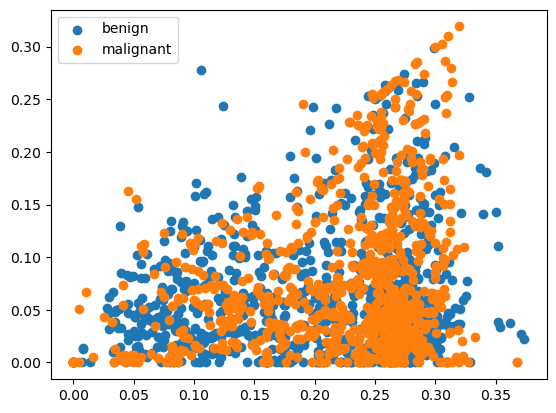

In [34]:
# summarize class distribution
counter = Counter(train_labels)
print(counter)
# transform the dataset
oversample = BorderlineSMOTE(random_state=42)
X, y = oversample.fit_resample(all_features,train_labels)
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

In [35]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
label_encoder = preprocessing.LabelEncoder()

In [36]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

In [37]:
label_encoder.fit(y)
train_labels=label_encoder.transform(y)

In [38]:
train_labels.shape

(1748,)

In [39]:
X_train=X
y_train=train_labels

In [40]:
X_train.shape

(1748, 6340)

In [41]:
y_train.shape

(1748,)

In [42]:
def calculate_specificity(confusion_matrix):
    true_negatives = confusion_matrix[1][1]
    false_positives = confusion_matrix[0][1]  
    specificity = true_negatives / (true_negatives + false_positives)
    return specificity

In [43]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1:
0.9771428571428571
              precision    recall  f1-score   support

      Benign     0.9941    0.9600    0.9767       175
   Malignant     0.9613    0.9943    0.9775       175

    accuracy                         0.9771       350
   macro avg     0.9777    0.9771    0.9771       350
weighted avg     0.9777    0.9771    0.9771       350



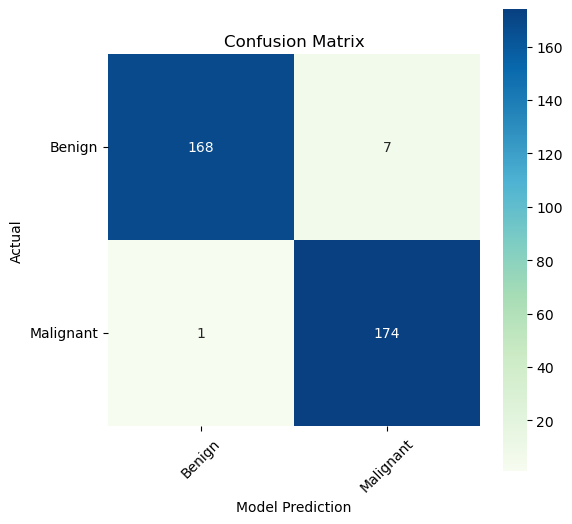

Specificity: 0.9613259668508287


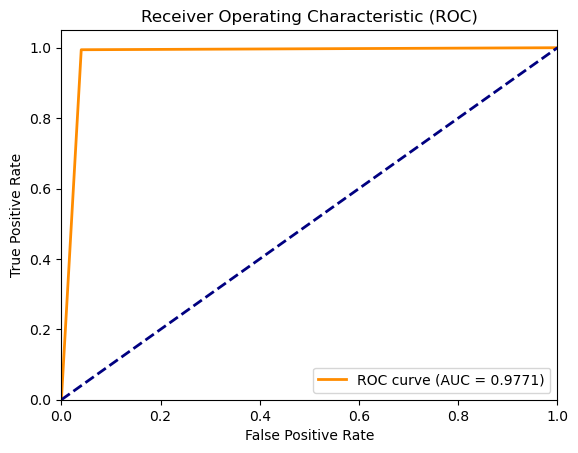

------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2:
0.9942857142857143
              precision    recall  f1-score   support

      Benign     1.0000    0.9886    0.9943       175
   Malignant     0.9887    1.0000    0.9943       175

    accuracy                         0.9943       350
   macro avg     0.9944    0.9943    0.9943       350
weighted avg     0.9944    0.9943    0.9943       350



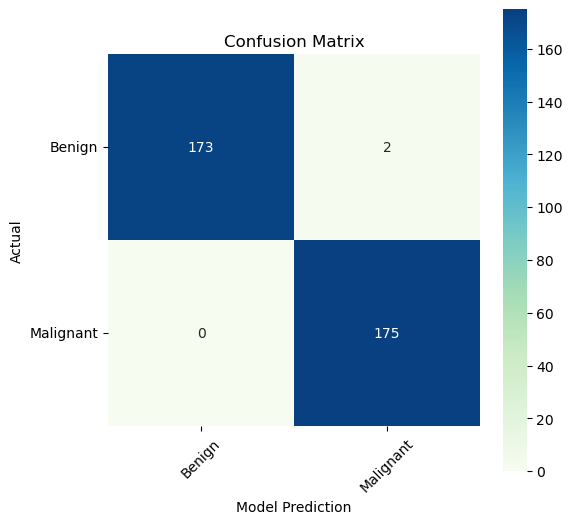

Specificity: 0.9887005649717514


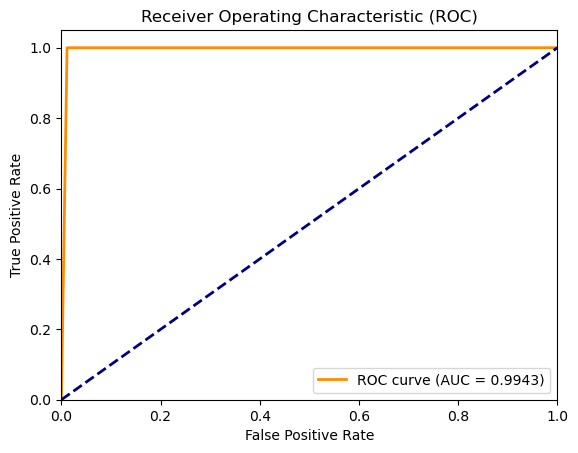

------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3:
1.0
              precision    recall  f1-score   support

      Benign     1.0000    1.0000    1.0000       175
   Malignant     1.0000    1.0000    1.0000       175

    accuracy                         1.0000       350
   macro avg     1.0000    1.0000    1.0000       350
weighted avg     1.0000    1.0000    1.0000       350



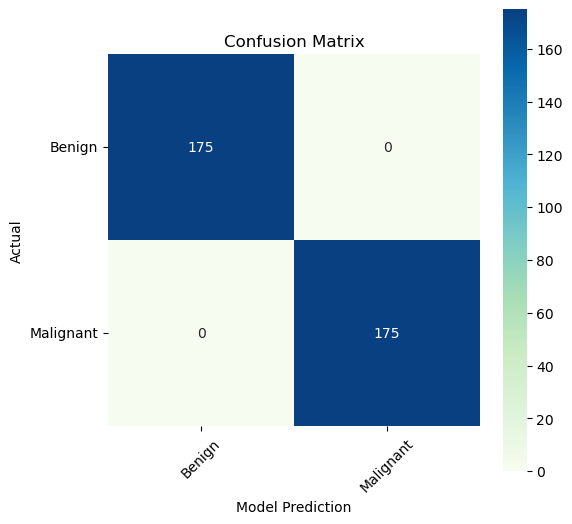

Specificity: 1.0


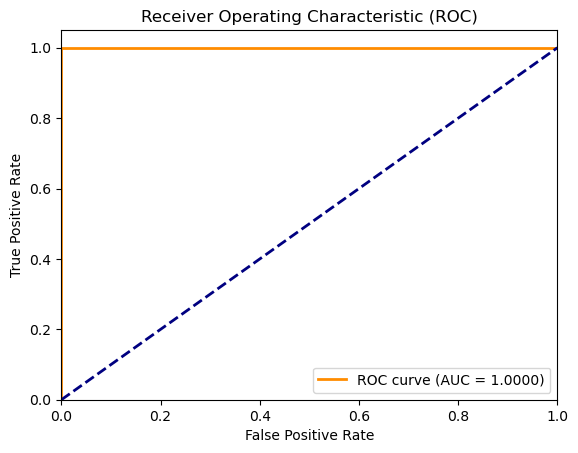

------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4:
0.994269340974212
              precision    recall  f1-score   support

      Benign     1.0000    0.9886    0.9943       175
   Malignant     0.9886    1.0000    0.9943       174

    accuracy                         0.9943       349
   macro avg     0.9943    0.9943    0.9943       349
weighted avg     0.9943    0.9943    0.9943       349



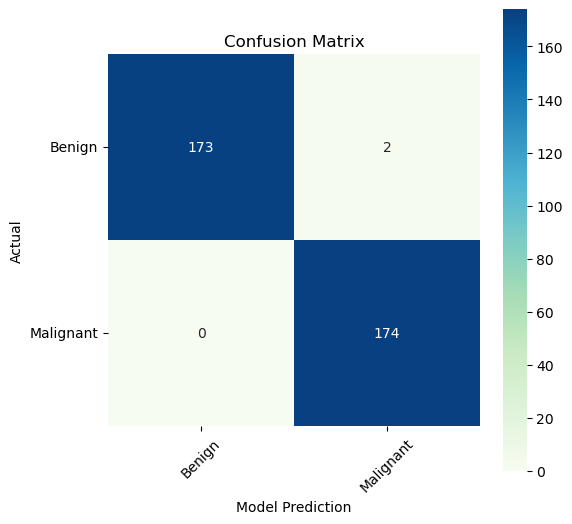

Specificity: 0.9886363636363636


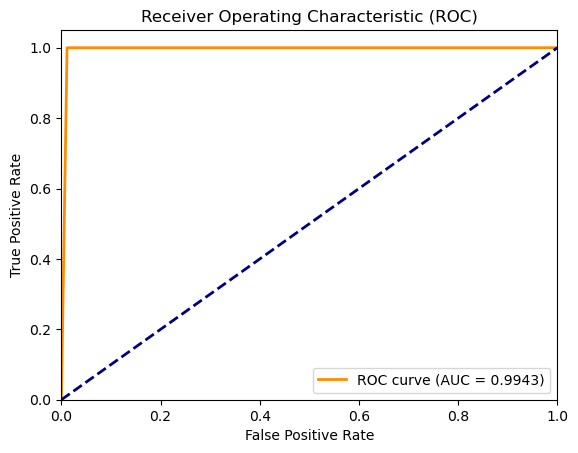

------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5:
0.997134670487106
              precision    recall  f1-score   support

      Benign     1.0000    0.9943    0.9971       174
   Malignant     0.9943    1.0000    0.9972       175

    accuracy                         0.9971       349
   macro avg     0.9972    0.9971    0.9971       349
weighted avg     0.9972    0.9971    0.9971       349



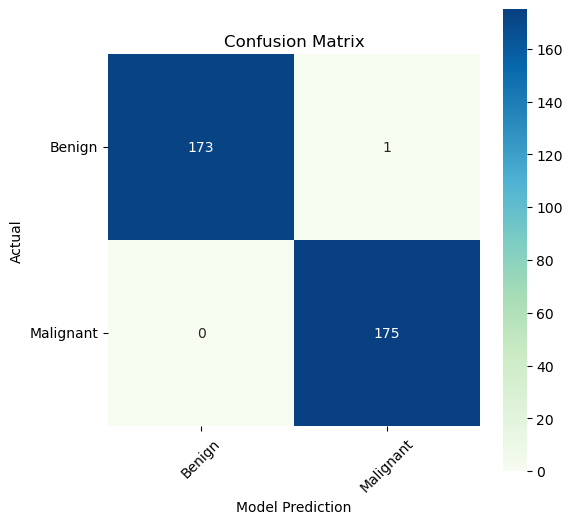

Specificity: 0.9943181818181818


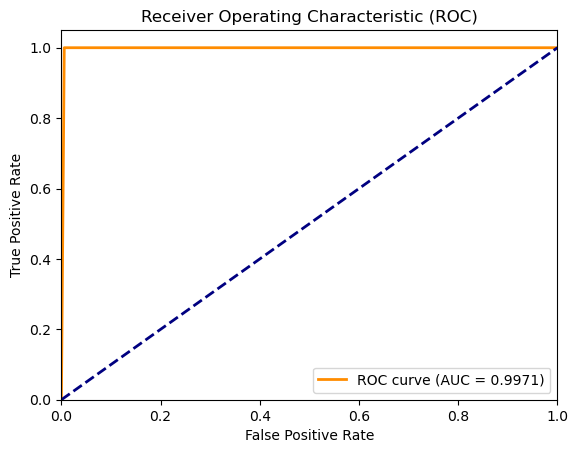

In [44]:
from sklearn.model_selection import StratifiedKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)
acc_per_fold = []
loss_per_fold = []
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X_train, y_train):
    model=svm.SVC(kernel = 'linear',gamma = 'scale') 
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    model.fit(X_train[train], y_train[train])
    print(f'Score for fold {fold_no}:')
    yhat=model.predict(X_train[test])
    ytrue=y_train[test]
    ypre=yhat
    print(accuracy_score(ytrue,ypre))
    from sklearn.metrics import classification_report
    target_names=['Benign','Malignant']
    print(classification_report(ytrue, ypre, target_names=target_names, digits=4))
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    plt.figure(1, figsize=(6, 6))

    mat = confusion_matrix(ytrue, ypre)

    axes = sns.heatmap(mat,square=True, annot=True,fmt='d',
                   cbar=True, cmap=plt.cm.GnBu)

    class_labels = ['Benign','Malignant']

    axes.set_xlabel('Model Prediction')
    axes.set_ylabel('Actual')

    tick_marks = np.arange(len(class_labels)) + 0.5

    axes.set_xticks(tick_marks)
    axes.set_xticklabels(class_labels,rotation=45)

    axes.set_yticks(tick_marks)
    axes.set_yticklabels(class_labels,rotation=0)

    axes.set_title('Confusion Matrix')
    plt.savefig("CM"+str(fold_no)+".png", dpi=400)
    plt.show()
    
    
    specificity = calculate_specificity(mat)
    print("Specificity:", specificity)
    
    
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(ytrue, ypre)
    auc_score = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
    fold_no = fold_no + 1

In [65]:
# WEIGHTED VOTING ENSEMBLE 

In [66]:
def Ensemble_accuracy(data1, data2):
    threshold = 0.5
    X_test = data1
    y_test = data2

    model1_predictions = model1.predict_proba(X_test)[:, 1]  # Take the second column
    model2_predictions = model2.decision_function(X_test)
    model3_predictions = model3.predict_proba(X_test)[:, 1]  # Take the second column

    weights = [0.43273674, 0.2897947, 0.27746856]
    weighted_average_predictions = (
        weights[0] * model1_predictions
        + weights[1] * model2_predictions
        + weights[2] * model3_predictions
    )
    
    binary_predictions = (weighted_average_predictions / sum(weights) > threshold).astype(int)

    ytrue = y_test
    ypre = binary_predictions
    
    return ytrue, ypre


In [67]:
X_train=X
y_train=train_labels

------------------------------------------------------------------------
Training for fold 1 ...
[LightGBM] [Info] Number of positive: 699, number of negative: 699
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1455063
[LightGBM] [Info] Number of data points in the train set: 1398, number of used features: 5894
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Score for fold 1:
0.9857142857142858
              precision    recall  f1-score   support

      Benign     0.9885    0.9829    0.9857       175
   Malignant     0.9830    0.9886    0.9858       175

    accuracy                         0.9857       350
   macro avg     0.9857    0.9857    0.9857       350
weigh

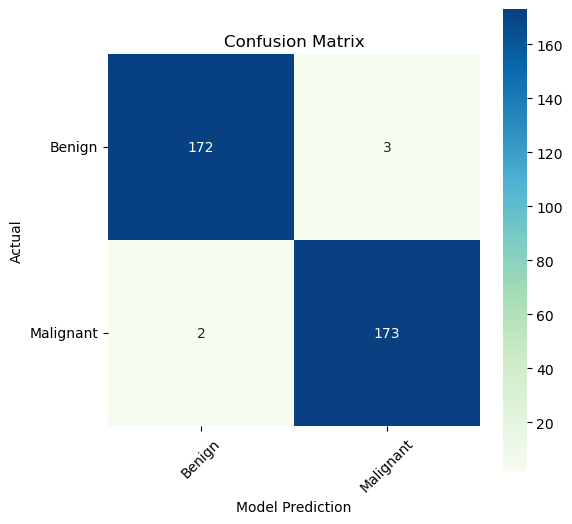

Specificity: 0.9829545454545454


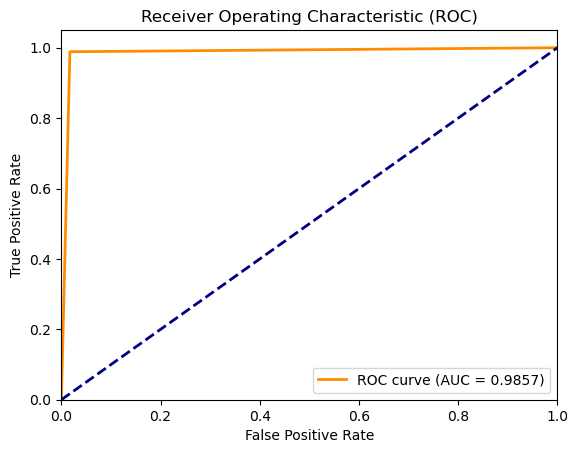

------------------------------------------------------------------------
Training for fold 2 ...
[LightGBM] [Info] Number of positive: 699, number of negative: 699
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1454903
[LightGBM] [Info] Number of data points in the train set: 1398, number of used features: 5894
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Score for fold 2:
0.9971428571428571
              precision    recall  f1-score   support

      Benign     0.9943    1.0000    0.9972       175
   Malignant     1.0000    0.9943    0.9971       175

    accuracy                         0.9971       350
   macro avg     0.9972    0.9971    0.9971       350
weigh

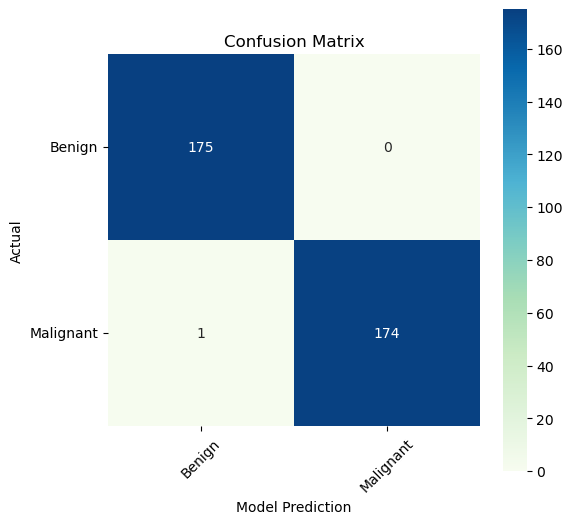

Specificity: 1.0


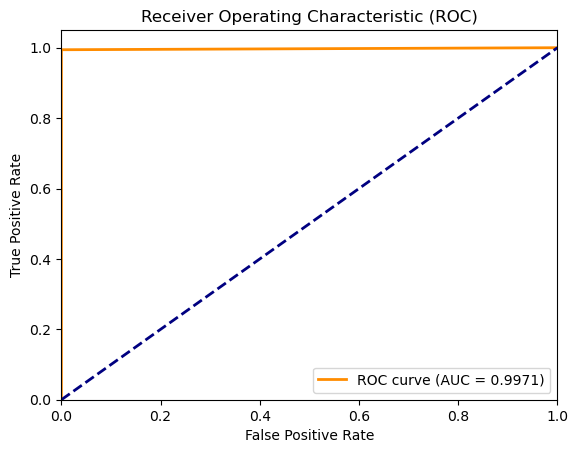

------------------------------------------------------------------------
Training for fold 3 ...
[LightGBM] [Info] Number of positive: 699, number of negative: 699
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1455289
[LightGBM] [Info] Number of data points in the train set: 1398, number of used features: 5893
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Score for fold 3:
1.0
              precision    recall  f1-score   support

      Benign     1.0000    1.0000    1.0000       175
   Malignant     1.0000    1.0000    1.0000       175

    accuracy                         1.0000       350
   macro avg     1.0000    1.0000    1.0000       350
weighted avg     1.0

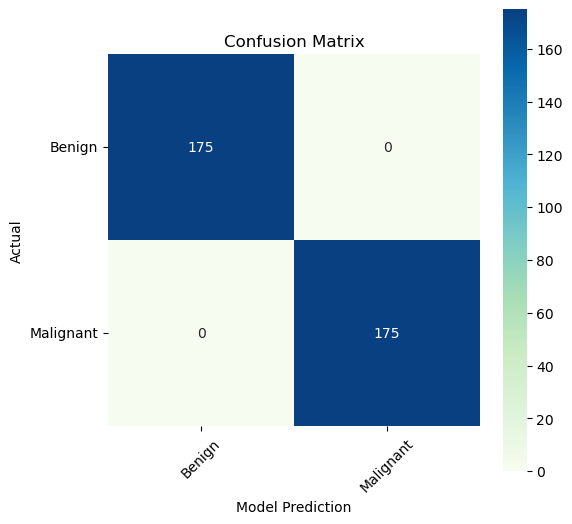

Specificity: 1.0


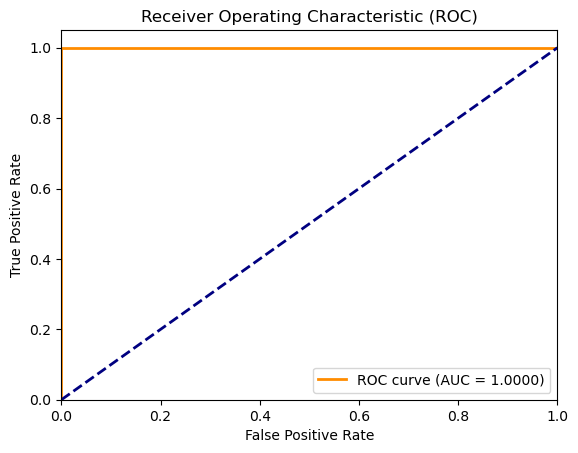

------------------------------------------------------------------------
Training for fold 4 ...
[LightGBM] [Info] Number of positive: 700, number of negative: 699
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1455607
[LightGBM] [Info] Number of data points in the train set: 1399, number of used features: 5894
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500357 -> initscore=0.001430
[LightGBM] [Info] Start training from score 0.001430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Score for fold 4:
0.997134670487106
              precision    recall  f1-score   support

      Benign     1.0000    0.9943    0.9971       175
   Malignant     0.9943    1.0000    0.9971       174

    accuracy                         0.9971       349
   macro avg     0.9971    0.9971    0.9971       349
weighted avg     0.9972    0

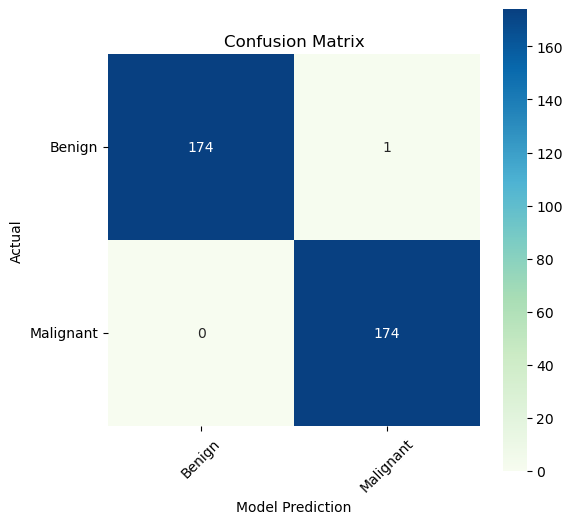

Specificity: 0.9942857142857143


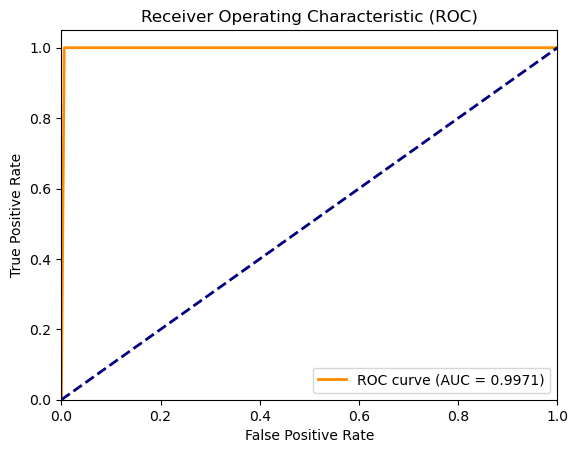

------------------------------------------------------------------------
Training for fold 5 ...
[LightGBM] [Info] Number of positive: 699, number of negative: 700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1454902
[LightGBM] [Info] Number of data points in the train set: 1399, number of used features: 5893
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499643 -> initscore=-0.001430
[LightGBM] [Info] Start training from score -0.001430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Score for fold 5:
0.9914040114613181
              precision    recall  f1-score   support

      Benign     0.9831    1.0000    0.9915       174
   Malignant     1.0000    0.9829    0.9914       175

    accuracy                         0.9914       349
   m

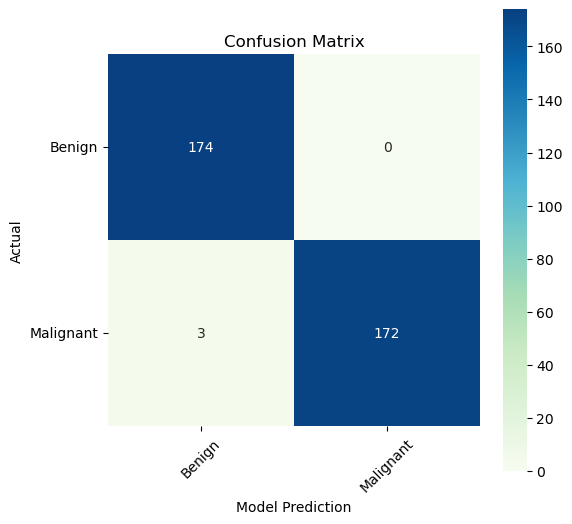

Specificity: 1.0


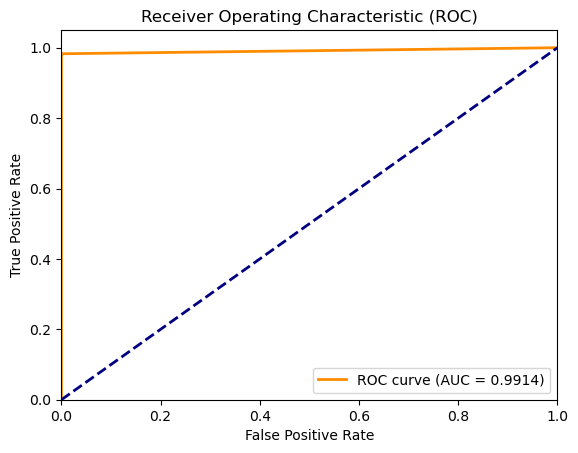

In [68]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)
acc_per_fold = []
loss_per_fold = []
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X_train, y_train):
    model1=ExtraTreesClassifier(n_estimators=100, random_state=0)
    model2=svm.SVC(kernel = 'linear',gamma = 'scale', probability=True) 
    model3=LGBMClassifier()
    #model4=XGBClassifier()
   
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    model1.fit(X_train[train], y_train[train])
    model2.fit(X_train[train], y_train[train])
    model3.fit(X_train[train], y_train[train])
    print(f'Score for fold {fold_no}:')
    ytrue,ypre= Ensemble_accuracy(X_train[test],y_train[test])
    #ytrue=y_train[test]
    #ypre=yhat
    print(accuracy_score(ytrue,ypre))
    from sklearn.metrics import classification_report
    target_names=['Benign','Malignant']
    print(classification_report(ytrue, ypre, target_names=target_names, digits=4))
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    plt.figure(1, figsize=(6, 6))

    mat = confusion_matrix(ytrue, ypre)

    axes = sns.heatmap(mat,square=True, annot=True,fmt='d',
                   cbar=True, cmap=plt.cm.GnBu)

    class_labels = ['Benign','Malignant']

    axes.set_xlabel('Model Prediction')
    axes.set_ylabel('Actual')

    tick_marks = np.arange(len(class_labels)) + 0.5

    axes.set_xticks(tick_marks)
    axes.set_xticklabels(class_labels,rotation=45)

    axes.set_yticks(tick_marks)
    axes.set_yticklabels(class_labels,rotation=0)

    axes.set_title('Confusion Matrix')
    plt.savefig("CM"+str(fold_no)+".png", dpi=1000)
    plt.show()
    
    
    specificity = calculate_specificity(mat)
    print("Specificity:", specificity)
    
    
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(ytrue, ypre)
    auc_score = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
    fold_no = fold_no + 1